In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from utils import *
import numpy as np
import tensorflow as tf
import pprint
import matplotlib.image as mpimg
%matplotlib inline

C:\Users\ProBook\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ProBook\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ProBook\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ProBook\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

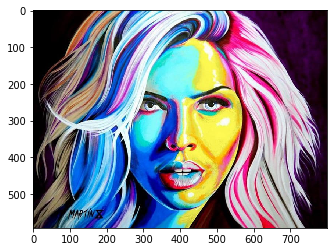

In [21]:
style_image = mpimg.imread("style_images/chica_azul.jpeg")
plt.imshow(style_image)

- *** Las layers profundas de una convnet detectan figuas complejas como objetos***
- *** Las layers pandas de una convnet detenctan figuras simples como lineas, ejes y texturas***

### Computar la funcion CONTENT COST
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

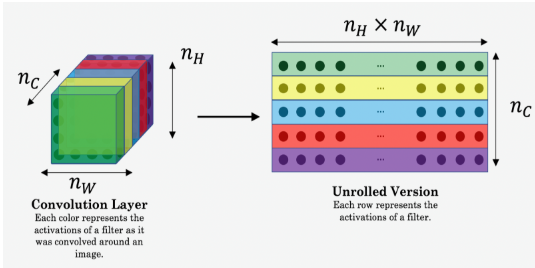

**PASOS:**
- traer las dimensiones de a_G
- desenrollar a_C y a_G de la manera que es mostrada en la imagen
- calcular la funcion costo

In [2]:
def compute_content_cost(a_C, a_G):
    """
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    J_content -- scalar result of compute content formula
    """
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (desenrrollar)
    a_C_unrolled = tf.reshape(a_C, shape = [m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [m, -1, n_C])
    
    # compute the cost
    J_content = tf.reduce_sum((a_C_unrolled - a_G_unrolled)**2)*(1/(4*n_H*n_W*n_C))    
    
    return J_content         

Resumen:
- la funcion content_cost toma las activaciones de la imagen content y la imagen generada, para medir que tan diferentes son

## computar la funcion style cost

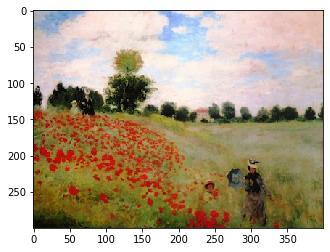

In [3]:
style_image = mpimg.imread("style_images/monet.jpg")
plt.imshow(style_image)

### Style matrix- gram matrix
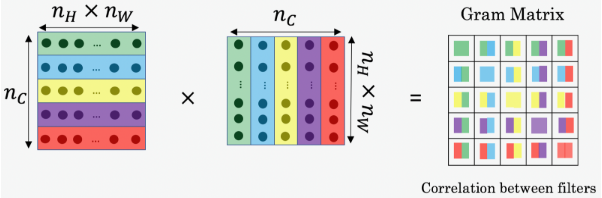
es el resultaado de multiplicar la matriz desenrollada por su transpuesta y mide que tan activo es un filtro al rededore de la imagen
$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

In [4]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A,tf.transpose(A))
    return GA

### Style cost

In [5]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    m, n_H, n_W, n_C = a_G.get_shape().as_list() #traer las dimensiones de la activacion
    
    a_S = tf.transpose(tf.reshape(a_S, shape = [n_H*n_W,n_C])) #cambiar las dimensiones a (n_C, n_H*n_W)
    a_G = tf.transpose(tf.reshape(a_G, shape = [n_H*n_W,n_C]))
    
    GS = gram_matrix(a_S) #creamos la matriz de style 
    GG = gram_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)), axis = None) / ((2*n_H*n_W*n_C)**2) #calcular la funcion loss
    
    return J_style_layer

### Style weights
modificar estos valores para canbiar el estilo

In [6]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

Para obtener mejores resultados miramos las diferencias en el estilo a traves de las distintas layers
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

donde los valores de $\lambda^{[l]}$ son dados por el STYLE_LAYERS que esta arriba

In [7]:
def compute_style_cost(model, STYLE_LAYERS):
    """        
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name] #seleccionamos solo la layer requerida
        a_S = sess.run(out) #corremos la sesion en esta para obtener sus activaciones        
        a_G = out
                
        J_style_layer = compute_layer_style_cost(a_S, a_G) #calculamos el style cost 

        J_style += coeff * J_style_layer #los multiplocamos por los coeficientes
        
    return J_style
    

Recordar:
- el style de una imagen puede ser representado usando la matriz de Gram 
- minimizar el costo de la funcion style hara que los estlos sean similares

## Definir el costo total a optimizar 
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [8]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """        
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha*J_content + beta*J_style
    return J

# Optimizacion

In [40]:
tf.reset_default_graph() #resetear las graph
sess = tf.InteractiveSession() #iniciar la sesion

C:\Users\ProBook\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


#### Cargamos la imagen content

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 400, 3)


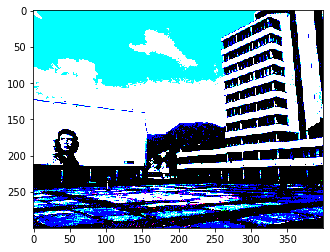

In [41]:
content_image = mpimg.imread("content_images/unal.jpg")
content_image = reshape_and_normalize_image(content_image) #normalizar la imagen
plt.imshow(content_image[0])

#### Cargamos la imagen style 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


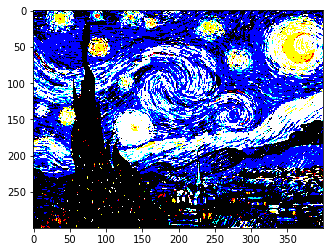

In [42]:
style_image = mpimg.imread("style_images/Starry-Night.jpg")
style_image = reshape_and_normalize_image(style_image) #normalizar la imagen
plt.imshow(style_image[0])

#### Generams la imagen generada

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


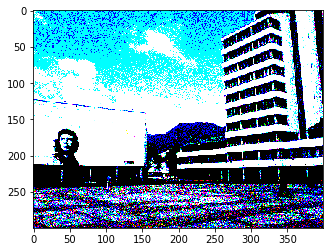

In [43]:
generated_image = generate_noise_image(content_image)
plt.imshow(generated_image[0])

#### Cargamos el modelo

In [58]:
import json
path = r"imagenet-vgg-verydeep-19.mat"
model = load_vgg_model(path)
model

{'input': <tf.Variable 'Variable_4:0' shape=(1, 300, 400, 3) dtype=float32_ref>,
 'conv1_1': <tf.Tensor 'Relu_64:0' shape=(1, 300, 400, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_65:0' shape=(1, 300, 400, 64) dtype=float32>,
 'avgpool1': <tf.Tensor 'AvgPool_20:0' shape=(1, 150, 200, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_66:0' shape=(1, 150, 200, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_67:0' shape=(1, 150, 200, 128) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_21:0' shape=(1, 75, 100, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_68:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_69:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_70:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_71:0' shape=(1, 75, 100, 256) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_22:0' shape=(1, 38, 50, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 'Relu_72:0' shape=(1, 38, 50, 512) dtype=float32>,
 'conv4

#### Asignamos el content cost como tensores

In [45]:
sess.run(model["input"].assign(content_image)) #asignamos la content image para ser el input del modelo vgg-19
out = model['conv4_2'] #seleccionamos el output
a_C = sess.run(out) #asignams el output de la imagen content
a_G = out #asignamos el output de la imagen generada
J_content = compute_content_cost(a_C, a_G) #calculamos la funcion loss para el content

#### Asignamos el style cost como tensores

In [46]:
sess.run(model['input'].assign(style_image)) #asignamos el input como la imagen generada

J_style = compute_style_cost(model, STYLE_LAYERS) #calcular el style cost

#### Asignamos el costo total

In [47]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

#### Asignar el optimizador

In [48]:
optimizer = tf.train.AdamOptimizer(2.0) #usamos adam con learning rate = 2
train_step = optimizer.minimize(J) #definimos el objetivo

### Implementamos el modelo

In [49]:
def model_nn(sess, input_image, num_iterations = 200):
    
    
    sess.run(tf.global_variables_initializer()) #inicializar variables globales
            
    sess.run(model["input"].assign(input_image)) #corremos la imagen inicial a traves del modelo    
    
    for i in range(num_iterations):            
        sess.run(train_step) #correr la sesion en el train_step para minimizar                                
        generated_image = sess.run(model['input']) #computar la imagen generada 
        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
                    
            save_image_2("output/" + str(i) + ".png", generated_image) #guardar la imagen del avance parcial            
        
    save_image_2('output/generated_image.jpg', generated_image) #guardar la imagen definitiva
    
    return generated_image

In [50]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 7646575000.0
content cost = 9505.164
style cost = 191162000.0
Iteration 20 :
total cost = 849184700.0
content cost = 20068.098
style cost = 21224600.0
Iteration 40 :
total cost = 258621740.0
content cost = 21935.508
style cost = 6460059.5
Iteration 60 :
total cost = 141278320.0
content cost = 22621.816
style cost = 3526302.5
Iteration 80 :
total cost = 94574210.0
content cost = 23019.434
style cost = 2358600.5
Iteration 100 :
total cost = 70868410.0
content cost = 23301.582
style cost = 1765884.9
Iteration 120 :
total cost = 57036520.0
content cost = 23531.037
style cost = 1420030.2
Iteration 140 :
total cost = 47975372.0
content cost = 23737.848
style cost = 1193449.8
Iteration 160 :
total cost = 41507656.0
content cost = 23929.705
style cost = 1031709.0
Iteration 180 :
total cost = 36629580.0
content cost = 24104.045
style cost = 909713.5


array([[[[ -33.215893 ,  -37.050163 ,    9.178809 ],
         [ -51.59863  ,  -45.385754 ,   27.511175 ],
         [ -60.239075 ,  -44.32941  ,   28.98538  ],
         ...,
         [  -5.7576485,  -85.17284  ,    3.7112408],
         [  17.64324  ,  -71.42487  ,   62.198174 ],
         [  60.696106 ,   80.566246 ,  128.72543  ]],

        [[  57.606136 ,   64.56779  ,  100.27479  ],
         [  50.609505 ,   66.10655  ,   87.85325  ],
         [  42.827244 ,   58.822166 ,  102.99265  ],
         ...,
         [ -91.526085 ,  -65.95526  ,  -40.972885 ],
         [  -8.1134615,  -71.15733  ,  -19.87022  ],
         [  52.18905  ,   44.882397 ,  121.86614  ]],

        [[  58.504654 ,   49.23999  ,   87.46032  ],
         [  54.123344 ,   61.70054  ,  100.55647  ],
         [  42.19363  ,   57.363686 ,   96.18739  ],
         ...,
         [-117.02998  ,  -60.921944 ,  -56.544453 ],
         [ -85.07936  ,  -69.4491   ,  -47.57435  ],
         [  56.341274 ,   20.179924 ,  115.67899  ]],

In [54]:
import cv2
style_image = mpimg.imread("style_images/Starry-Night.jpg")

plt.imshow(style_image)

SyntaxError: invalid syntax (<ipython-input-54-ef6ef8984a2d>, line 1)